### Importing Packages

In [52]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from PIL import Image
import torch.nn.functional as F
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, precision_recall_fscore_support
from torchvision import models
from torchsummary import summary
from sklearn.model_selection import KFold
import warnings  
warnings.filterwarnings("ignore")

In [2]:
config = {
    'images_folder': '/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Final_Data/Mask Dataset',
    'train_batch_size': 128,
    'test_batch_size': 128,
    'num_epochs': 20,
    'learning_rate': 0.001
}

savedModel = False
model_path = '/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Model'
model_file_name= '/part2_cnn_mask_classification_4_cl_2_pl.pt'

In [3]:
def get_images(images_path, test_split=0.20):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([32, 32]),
                                    transforms.Normalize((0.5202, 0.4792, 0.4603), (0.2875, 0.2841, 0.2846))])
    dataset = ImageFolder(images_path, transform=transform)
    classLabels = dataset.class_to_idx;
    classImages = dict(Counter(dataset.targets))

    # Plotting the bar graph of the data
    keys = ["Cloth Mask", "Mask Worn Incorrectly", "N95 Mask", "No Face Mask", "Surgical Mask"]
    values = list(classImages.values())
    plt.bar(keys, values, color ='blue',width = 0.4)
    plt.xlabel("Type of classes")
    plt.ylabel("Number of images")
    plt.title("Number of images in each mask type")
    plt.xticks(rotation = 90)
    plt.show()

    # Showing count of each image
    print("\n")
    for k in keys:
      print(k + ": " + str(classImages[classLabels[k]]))

    #train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    #train = Subset(dataset, train_idx)
    #test = Subset(dataset, test_idx)

    return dataset

### Getting Data

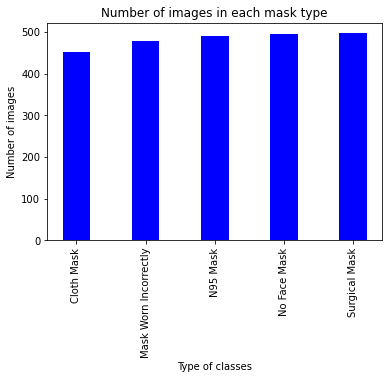



Cloth Mask: 453
Mask Worn Incorrectly: 478
N95 Mask: 491
No Face Mask: 494
Surgical Mask: 497


In [4]:
dataset = get_images(config['images_folder'])

In [5]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

### CNN Model

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_layer = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


### Model Training Class 

In [7]:
class ModelTraining:
    def __init__(self, model, device, optimizer, criteria):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criteria = criteria

    def training(self, train_dataloader, epochs):
        total_no_of_steps = len(train_dataloader)
        accuracyList = []
        trainingLoss = []
        for epoch in range(epochs):
            self.model.train()
            train_total = 0
            train_correct = 0
            for i, (images, labels) in enumerate(train_dataloader):
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                loss = self.criteria(outputs, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.shape[0]
                train_correct += (predicted == labels).sum().item()
            print(
                f'Epoch {epoch + 1} / {epochs}, Training loss = {loss.item():.4f}, Training accuracy = {(train_correct / train_total) * 100}')
            accuracyList.append((train_correct / train_total) * 100)
            trainingLoss.append(loss.item())
        return accuracyList, trainingLoss

 #### Getting the accuracy of the model

In [8]:
def getModelAccuracy(model, test_dataloader, device):
    model.eval()
    total = 0
    correct = 0
    y_pred = []
    y_true = []
    precision = dict()
    recall = dict()
    avg = dict()
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            model_pred_on_test = model(images)
            model_pred_on_test = torch.argmax(F.softmax(model_pred_on_test.data), 1)
            predicted = model_pred_on_test
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
            if y_pred == []:
              y_true = labels[:]
              y_pred = model_pred_on_test[:]
            else:
              y_true = torch.hstack([y_true, labels])
              y_pred = torch.hstack([y_pred, model_pred_on_test])
        print('Test Accuracy of the model on the test images: {} %'
              .format((correct / total) * 100))
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_true.cpu().detach().numpy()
        target_names = ["Cloth Mask", "Mask Worn Incorrectly", "N95 Mask", "No Face Mask", "Surgical Mask"]
        labels_names = [0, 1, 2, 3, 4]
        print(classification_report(y_true, y_pred, labels=labels_names, target_names=target_names))
        cm = confusion_matrix(y_true, y_pred, labels=labels_names)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
        plt.xticks(rotation = 90)
        plt.show()


 #### K Fold

======================== Fold No : 0 ===========================
================================= Model Summary =====================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2

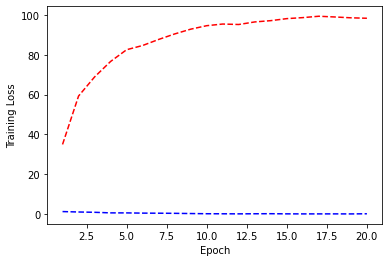

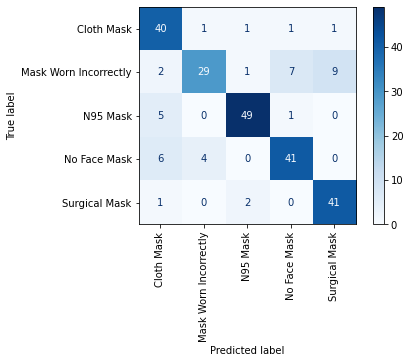

======================== Fold No : 1 ===========================
================================= Model Summary =====================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2

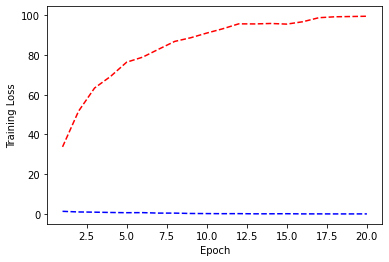

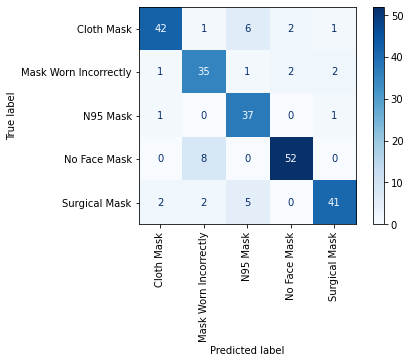

======================== Fold No : 2 ===========================
================================= Model Summary =====================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2

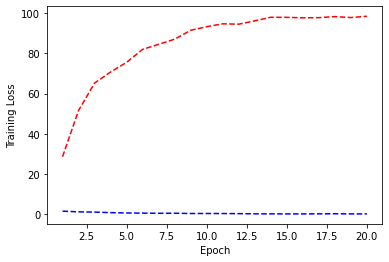

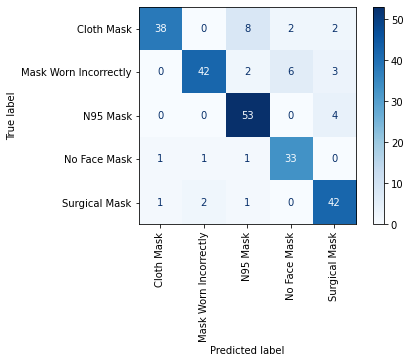

======================== Fold No : 3 ===========================
================================= Model Summary =====================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2

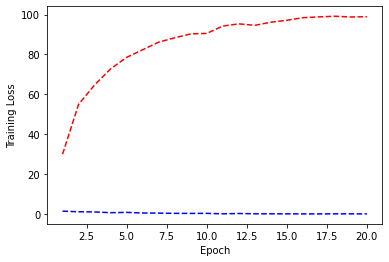

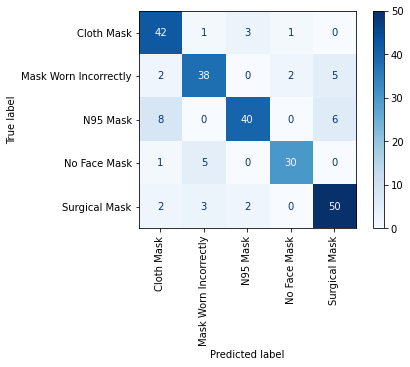

======================== Fold No : 4 ===========================
================================= Model Summary =====================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2

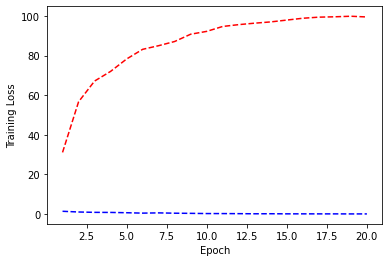

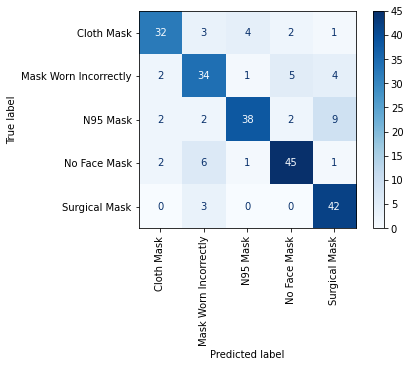

======================== Fold No : 5 ===========================
================================= Model Summary =====================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2

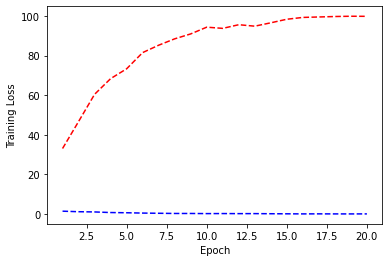

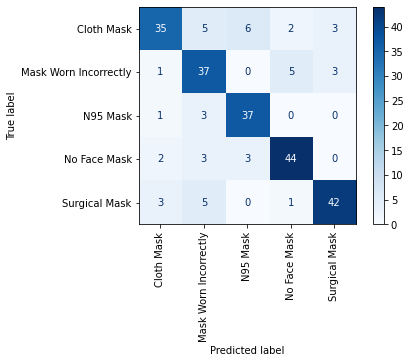

======================== Fold No : 6 ===========================
================================= Model Summary =====================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2

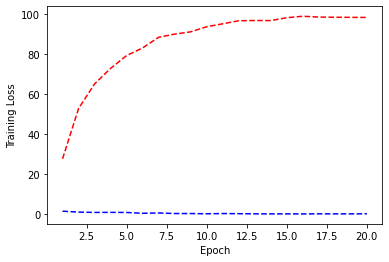

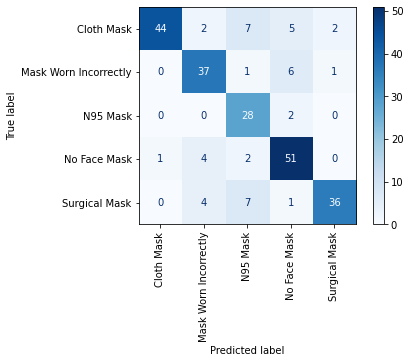

======================== Fold No : 7 ===========================
================================= Model Summary =====================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2

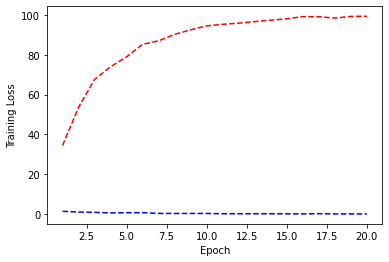

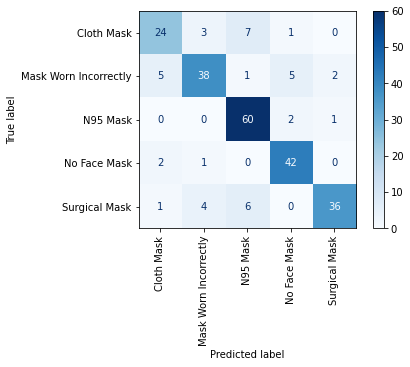

======================== Fold No : 8 ===========================
================================= Model Summary =====================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2

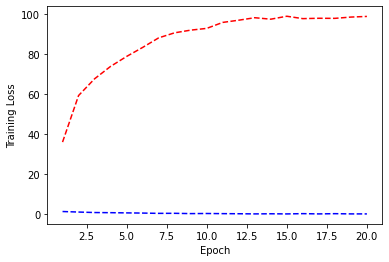

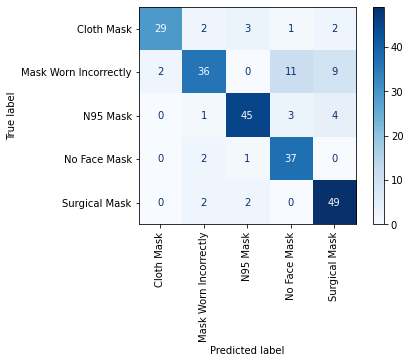

======================== Fold No : 9 ===========================
================================= Model Summary =====================================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2

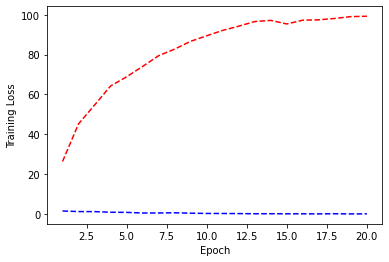

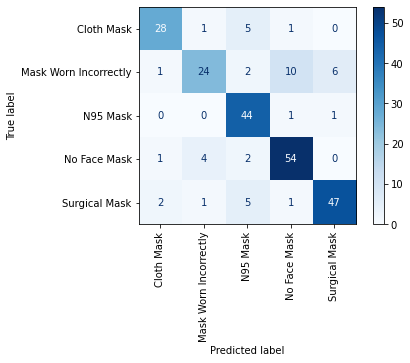

In [9]:
no_of_fold = 10
splits=KFold(n_splits=no_of_fold,shuffle=True,random_state=42)
for fold,(train_idx,test_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('======================== Fold No : '+str(format(fold))+' ===========================')
    train_subsampler = SubsetRandomSampler(train_idx)
    test_subsampler = SubsetRandomSampler(test_idx)
 
    train_dataloader = DataLoader(dataset,batch_size=config["train_batch_size"], sampler=train_subsampler)
    test_dataloader = DataLoader(dataset,batch_size=config["test_batch_size"], sampler=test_subsampler)
    
    model = Model()
    model = model.to(device)
    print('================================= Model Summary =====================================')
    summary(model, (3, 32, 32))
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.CrossEntropyLoss()
    model_trainer = ModelTraining(model=model, device=device, optimizer=optimizer, criteria=criterion)
    accuracyList, trainingLossList = model_trainer.training(train_dataloader, epochs=config["num_epochs"])
    torch.save(model.state_dict(),model_path+model_file_name+"_fold_no_"+str(format(fold)))
    
    fig1 = plt.plot(range(1, config['num_epochs']+1), accuracyList, 'r--')
    plt.xlabel('Epoch')
    plt.ylabel('Training accuracy')
    
    fig2 = plt.plot(range(1, config['num_epochs']+1), trainingLossList, 'b--')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    
    getModelAccuracy(model, test_dataloader, device)

# Performance evalution of  the chosen biasattribute subset(s)

In [63]:
import matplotlib.pyplot as plt

In [64]:
def get_images_subset(images_path):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([32, 32]),
                                    transforms.Normalize((0.5202, 0.4792, 0.4603), (0.2875, 0.2841, 0.2846))])
    dataset = ImageFolder(images_path, transform=transform)
    return dataset

In [65]:
#best_fold_no = 2
model_file_name_to_test = "/part2_cnn_mask_classification_4_cl_2_pl.pt_fold_no_"+str(best_fold_no)

images_folder_test_female = '/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Final_Data/Test_Data_Final/Test_Dataset_Female'
images_folder_test_male = '/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Final_Data/Test_Data_Final/Test_Dataset_Male'

images_folder_test_age1 = '/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Final_Data/Test_Data_Final/Test_Dataset_AgeGroup1'
images_folder_test_age2 = '/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Final_Data/Test_Data_Final/Test_Dataset_AgeGroup2'
images_folder_test_age3 = '/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Final_Data/Test_Data_Final/Test_Dataset_AgeGroup3'

In [66]:
model_test = Model()
model_test.load_state_dict(torch.load(model_path+model_file_name_to_test, torch.device(device)))
model_test.eval()
model_test.to(device)
summary(model_test, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
        LeakyReLU-13           [-1, 64, 16, 16]               0
        MaxPool2d-14             [-1, 6

# Female Dataset

Female Dataset
Test Accuracy of the model on the test images: 93.6842105263158 %
                       precision    recall  f1-score   support

           Cloth Mask       0.86      0.95      0.90        20
Mask Worn Incorrectly       0.93      0.93      0.93        15
             N95 Mask       0.95      0.95      0.95        20
         No Face Mask       1.00      0.85      0.92        20
        Surgical Mask       0.95      1.00      0.98        20

             accuracy                           0.94        95
            macro avg       0.94      0.94      0.94        95
         weighted avg       0.94      0.94      0.94        95



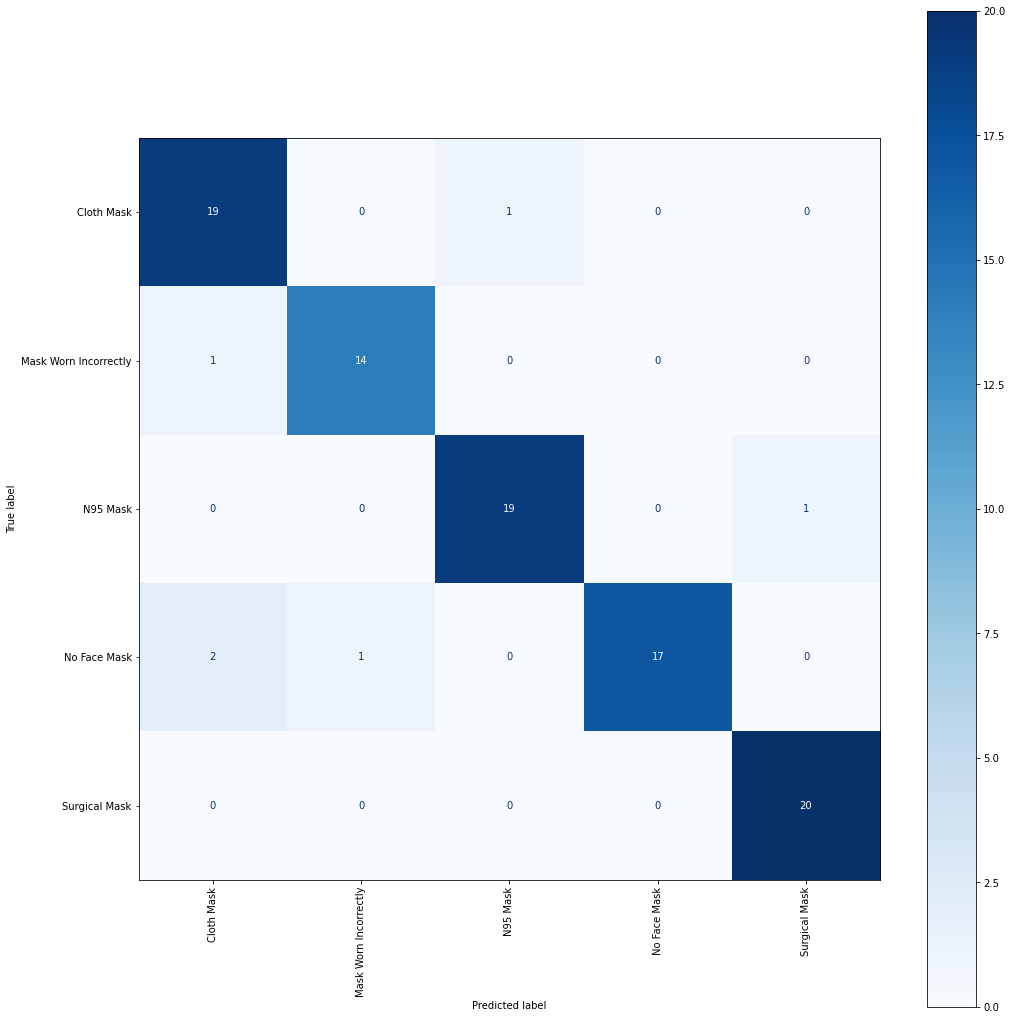

In [67]:
test_data_female = get_images_subset(images_folder_test_female)
test_dataloader_female = DataLoader(test_data_female, batch_size=config["test_batch_size"], shuffle=False)
print("Female Dataset")
getModelAccuracy(model_test, test_dataloader_female, device)

# Male

Male Dataset
Test Accuracy of the model on the test images: 98.9795918367347 %
                       precision    recall  f1-score   support

           Cloth Mask       0.95      1.00      0.98        20
Mask Worn Incorrectly       1.00      1.00      1.00        20
             N95 Mask       1.00      0.94      0.97        18
         No Face Mask       1.00      1.00      1.00        20
        Surgical Mask       1.00      1.00      1.00        20

             accuracy                           0.99        98
            macro avg       0.99      0.99      0.99        98
         weighted avg       0.99      0.99      0.99        98



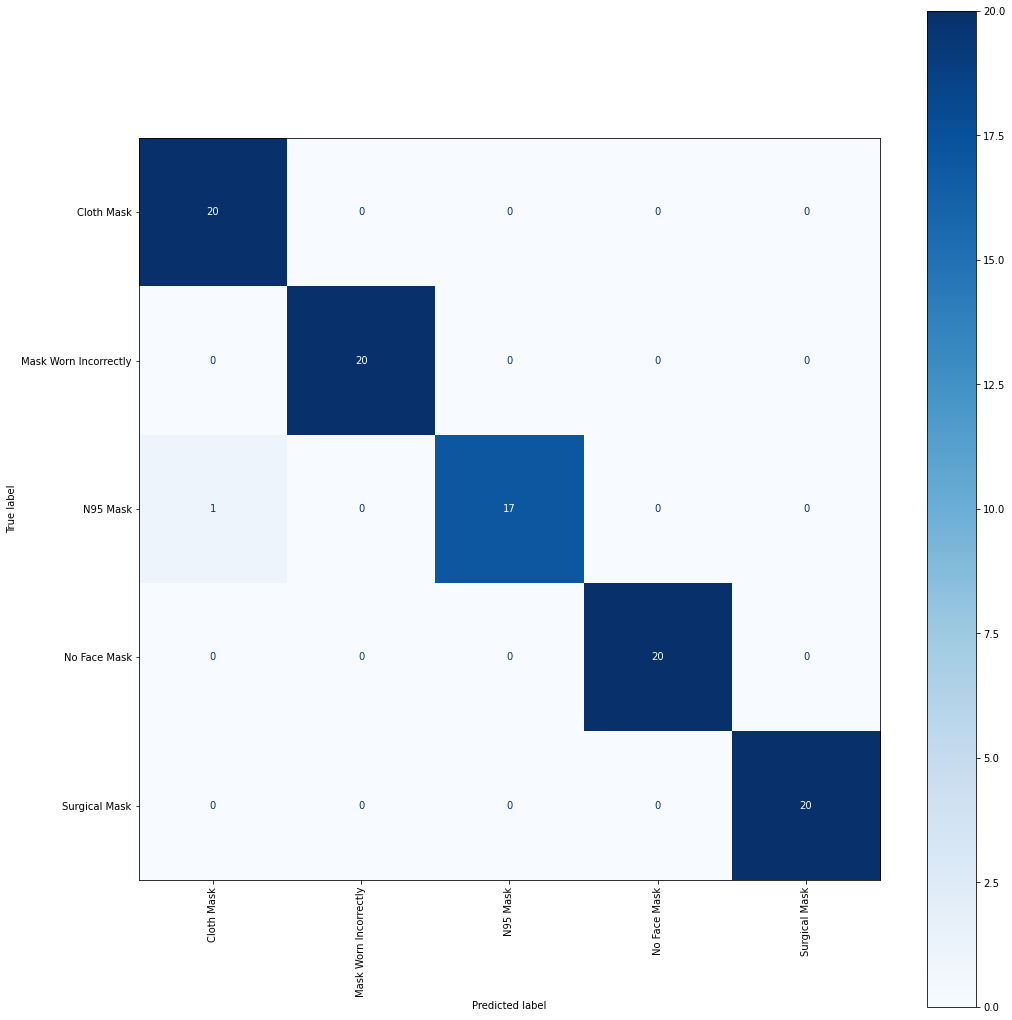

In [68]:
test_data_male = get_images_subset(images_folder_test_male)
test_dataloader_male = DataLoader(test_data_male, batch_size=config["test_batch_size"], shuffle=False)
print("Male Dataset")
getModelAccuracy(model_test, test_dataloader_male, device)

# Age Group 1 (0-25)

Age Group 1 (0-25) Dataset
Test Accuracy of the model on the test images: 99.0 %
                       precision    recall  f1-score   support

           Cloth Mask       1.00      1.00      1.00        20
Mask Worn Incorrectly       1.00      1.00      1.00        20
             N95 Mask       1.00      0.95      0.97        20
         No Face Mask       1.00      1.00      1.00        20
        Surgical Mask       0.95      1.00      0.98        20

             accuracy                           0.99       100
            macro avg       0.99      0.99      0.99       100
         weighted avg       0.99      0.99      0.99       100



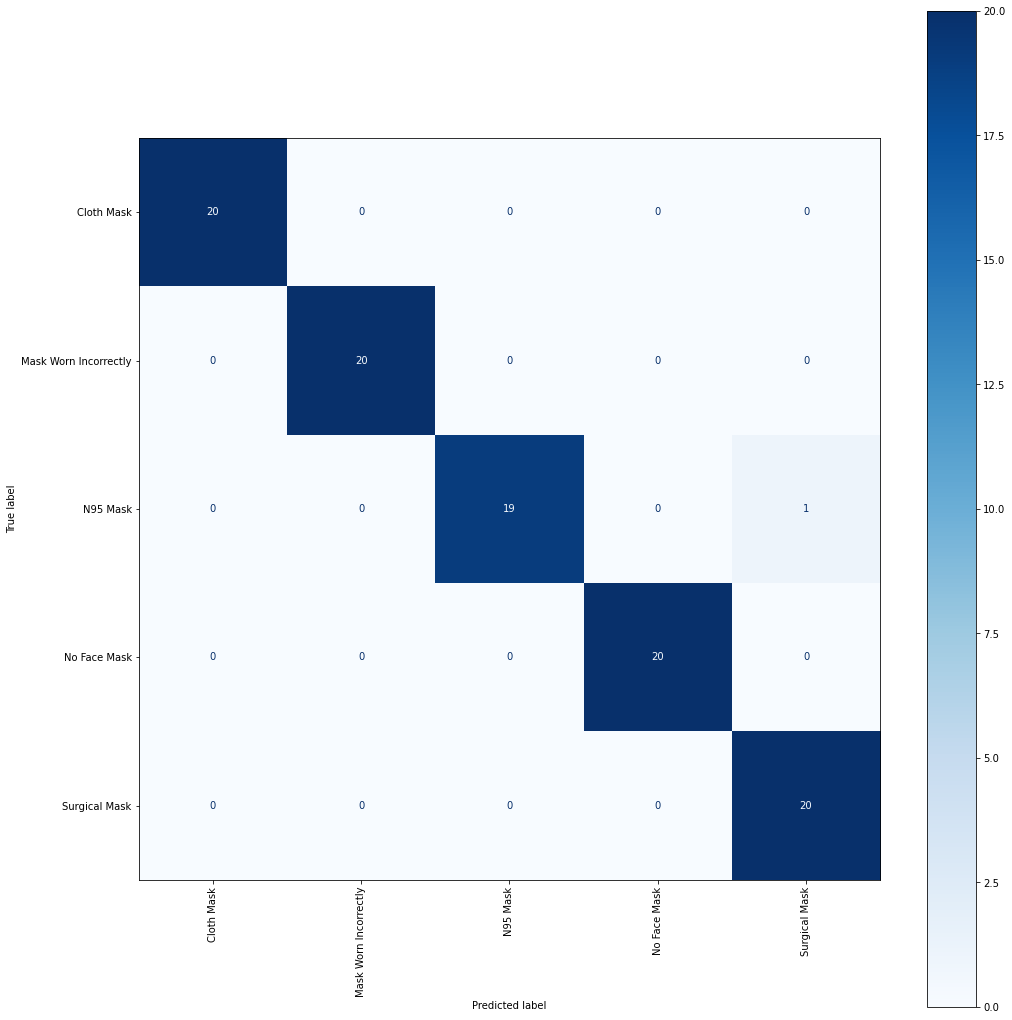

In [69]:
test_data_age1 = get_images_subset(images_folder_test_age1)
test_dataloader_age1 = DataLoader(test_data_age1, batch_size=config["test_batch_size"], shuffle=False)
print("Age Group 1 (0-25) Dataset")
getModelAccuracy(model_test, test_dataloader_age1, device)

# Age Group 2 (26-50)

Age Group 2 (26-50) Dataset
Test Accuracy of the model on the test images: 95.0 %
                       precision    recall  f1-score   support

           Cloth Mask       0.86      0.95      0.90        20
Mask Worn Incorrectly       1.00      0.95      0.97        20
             N95 Mask       1.00      0.95      0.97        20
         No Face Mask       0.95      0.90      0.92        20
        Surgical Mask       0.95      1.00      0.98        20

             accuracy                           0.95       100
            macro avg       0.95      0.95      0.95       100
         weighted avg       0.95      0.95      0.95       100



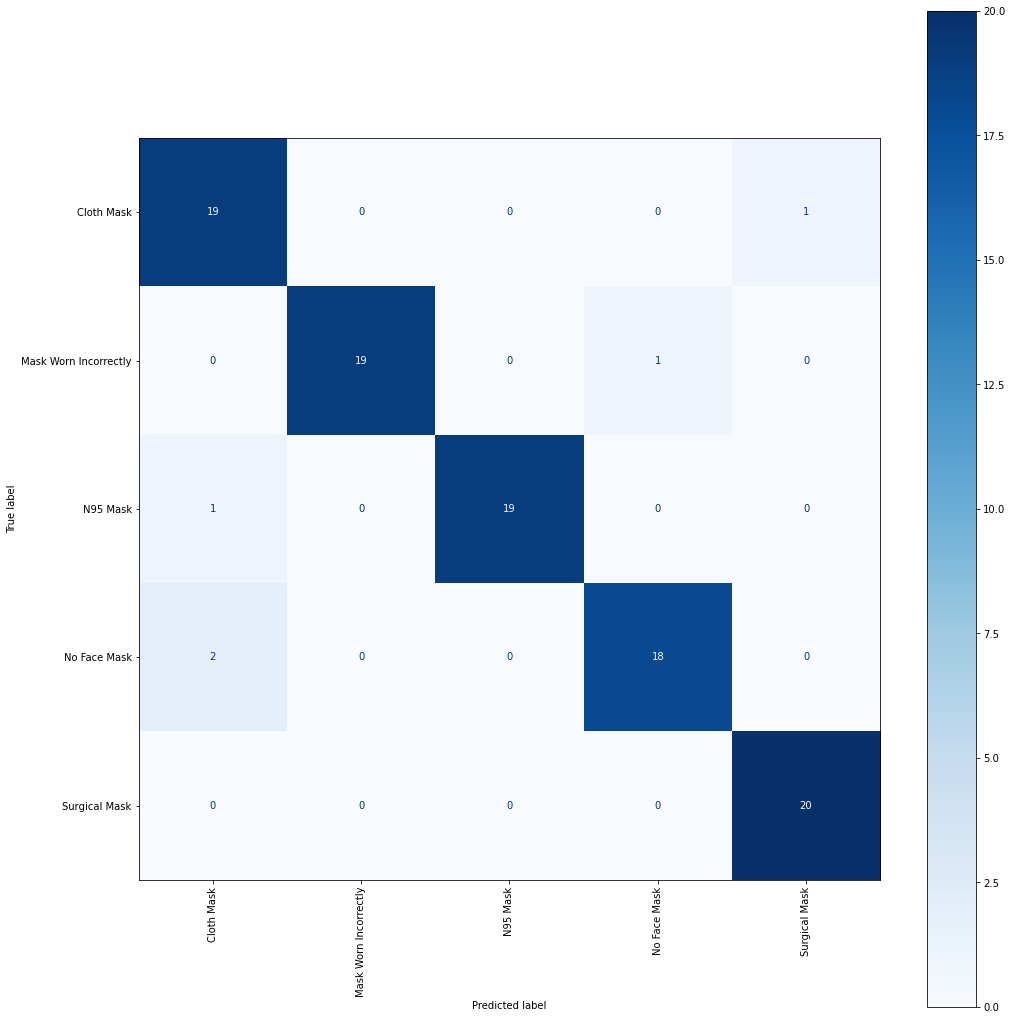

In [70]:
test_data_age2 = get_images_subset(images_folder_test_age2)
test_dataloader_age2 = DataLoader(test_data_age2, batch_size=config["test_batch_size"], shuffle=False)
print("Age Group 2 (26-50) Dataset")
getModelAccuracy(model_test, test_dataloader_age2, device)

# Age Group 3 (51+)

Age Group 3 (51+) Dataset
Test Accuracy of the model on the test images: 77.0 %
                       precision    recall  f1-score   support

           Cloth Mask       0.56      0.50      0.53        20
Mask Worn Incorrectly       0.85      0.85      0.85        20
             N95 Mask       0.66      0.95      0.78        20
         No Face Mask       0.90      0.95      0.93        20
        Surgical Mask       1.00      0.60      0.75        20

             accuracy                           0.77       100
            macro avg       0.79      0.77      0.77       100
         weighted avg       0.79      0.77      0.77       100



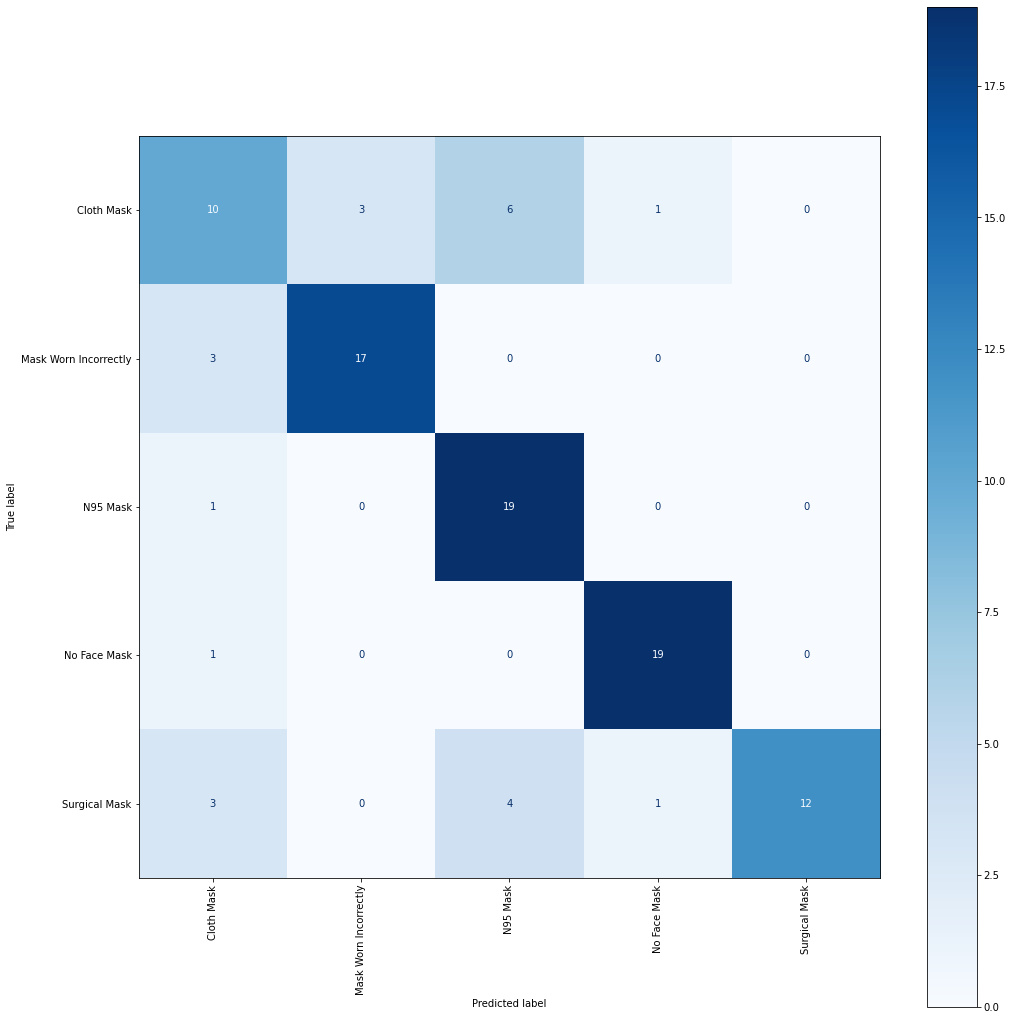

In [71]:
test_data_age3 = get_images_subset(images_folder_test_age3)
test_dataloader_age3 = DataLoader(test_data_age3, batch_size=config["test_batch_size"], shuffle=False)
print("Age Group 3 (51+) Dataset")
getModelAccuracy(model_test, test_dataloader_age3, device)

# Predicting single image of five classes

#### predict_image class

In [53]:
def predict_image(model, image, device, labels=["Cloth Mask", "Mask Worn Incorrectly", "N95 Mask", "No Face Mask", "Surgical Mask"]):

    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
    pred = output.argmax(dim=1).cpu().numpy()
    return labels[pred[0]]

#### preparing pred data

In [54]:
import glob
import pandas as pd
application_image_directory='/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Final_Data/Application Mask Dataset'
labels=["Cloth Mask", "Mask Worn Incorrectly", "N95 Mask", "No Face Mask", "Surgical Mask"]
data_image = []
actual_value  = []
images_path=glob.glob(application_image_directory+'/*.jpeg')
for i in images_path:
    data_image.append(i)
application_image_df = pd.DataFrame(data_image, columns=['Name'])

#### predicting images (application mode)

Model Prediction on Application ImageSet


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


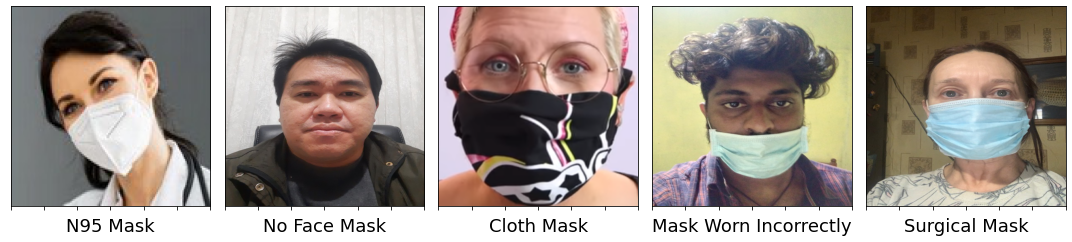

In [55]:
print('Model Prediction on Application ImageSet')
#plt.title(label =,loc="center", fontsize=29)
plt.rcParams["figure.figsize"] = [15.00, 15.00]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1,5)
for i in range(len(application_image_df)) :
    imageFile = application_image_df.loc[i, "Name"]
    image = Image.open(imageFile)
    
    transform = transforms.Compose(
          [transforms.ToTensor(),
            transforms.Resize((32, 32)),
            transforms.Normalize((0.5202, 0.4792, 0.4603), (0.2875, 0.2841, 0.2846))]
      )
    image = transform(image)
    predicted_mask_class = predict_image(model, image, device)
    
    application_image = plt.imread(imageFile)
    application_image = ax[i].imshow(application_image, extent=[0, 300, 0, 300])
    ax[i].axes.yaxis.set_visible(False)
    ax[i].axes.xaxis.set_ticklabels([])
    ax[i].set_xlabel(predicted_mask_class, fontsize=18)
plt.show()